In [147]:
## Configuration
"""
Set up the parameters for creating a grid shapefile for a specific region and dataset.
@param plotName - Name of the plot or region.
@param shapefile_path - Path to the shapefile for the region.
@param output_path - Path to save the grid shapefile.
@param grid_size - Size of the grid cells.
@param dataset_file_path - Path to the dataset file.
@param interested_column - List of columns of interest in the dataset.
"""

# country/area/region
plotName = "Mexico"

# Input shapefile or GeoJSON of country/area/region
shapefile_path = "../samples/mexico/mexico_.geojson"

# Output path for the grid shapefile
output_path = "../outputs/mexico_grid.shp"

# Define the grid size (e.g., 1 degree for lat/lon)
grid_size = 1.0

# dataset file path
dataset_file_path = '../datasets/mexico_soil_wosis_merged.csv'

# interested column
interested_column = ['orgc_value', 'tceq_value']

In [148]:
import geopandas as gpd
import numpy as np
from shapely.geometry import box

def create_grid(shapefile_path, output_path, grid_size):
    """
    Divide a shapefile of Mexico into equal grids and save the grid shapefile.

    Parameters:
    shapefile_path (str): Path to the input shapefile or GeoJSON.
    output_path (str): Path to save the output grid shapefile.
    grid_size (float): Size of the grid cells (in degrees for lat/lon).
    """
    # Load the shapefile
    country = gpd.read_file(shapefile_path)

    # Get the bounding box of the shapefile
    minx, miny, maxx, maxy = country.total_bounds

    # Generate grid coordinates
    x_coords = np.arange(minx, maxx, grid_size)
    y_coords = np.arange(miny, maxy, grid_size)

    # Create grid cells
    grid_cells = []
    for x in x_coords:
        for y in y_coords:
            grid_cells.append(box(x, y, x + grid_size, y + grid_size))

    # Create a GeoDataFrame for the grid with the same CRS as country
    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=country.crs)

    # Clip the grid to the shape of country
    grid = gpd.clip(grid, country)

    # Save the grid to a new shapefile
    grid.to_file(output_path, driver="ESRI Shapefile")

    return grid

# Create the grid
grid = create_grid(shapefile_path, output_path, grid_size)
print(f"Grid created and saved to {output_path}")


Grid created and saved to ../outputs/mexico_grid.shp


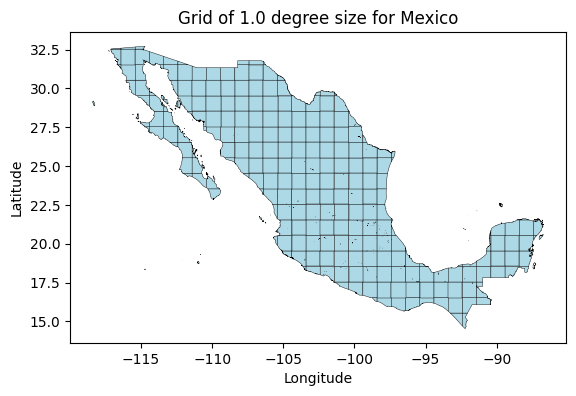

In [149]:
import matplotlib.pyplot as plt
# preview grid
grid.plot(edgecolor='black', facecolor='lightblue', linewidth=0.3)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f"Grid of {grid_size} degree size for {plotName}")
plt.show()

In [150]:
import pandas as pd
from shapely.geometry import Point

# load dataset
data = pd.read_csv(dataset_file_path)

# only interested column
data = data[interested_column +
            ['longitude', 'latitude']
            ].copy()

# create geometry from lat/lon
data['geometry'] = data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# convert to geodataframe
data_gdf = gpd.GeoDataFrame(data, geometry='geometry', crs=grid.crs)

# merge with grid
grid_data = gpd.sjoin(grid, data_gdf, how="inner", predicate="contains")

# drop index
grid_data = grid_data.drop(columns=['index_right'])

In [151]:
print(f"Grid data shape: {grid_data.shape}")
# table view
grid_data.head(10)

Grid data shape: (8206, 5)


,geometry,orgc_value,tceq_value,longitude,latitude
362,"MULTIPOLYGON (((-98.40765 16.5321, -98.40765 1...",3.0,0.0,-98.509033,16.363333
362,"MULTIPOLYGON (((-98.40765 16.5321, -98.40765 1...",5.0,0.0,-98.509033,16.363333
362,"MULTIPOLYGON (((-98.40765 16.5321, -98.40765 1...",13.0,0.0,-98.529334,16.429971
362,"MULTIPOLYGON (((-98.40765 16.5321, -98.40765 1...",NaN,NaN,-98.563737,16.493250
362,"MULTIPOLYGON (((-98.40765 16.5321, -98.40765 1...",NaN,NaN,-98.737403,16.531580
362,"MULTIPOLYGON (((-98.40765 16.5321, -98.40765 1...",27.0,0.0,-98.561436,16.531646
362,"MULTIPOLYGON (((-98.40765 16.5321, -98.40765 1...",17.0,0.0,-98.561436,16.531646
344,"MULTIPOLYGON (((-100.40765 17.5321, -99.40765 ...",3.0,0.0,-99.686267,16.717850
344,"MULTIPOLYGON (((-100.40765 17.5321, -99.40765 ...",20.0,0.0,-99.457195,16.734881
344,"MULTIPOLYGON (((-100.40765 17.5321, -99.40765 ...",12.0,0.0,-99.656828,16.749868


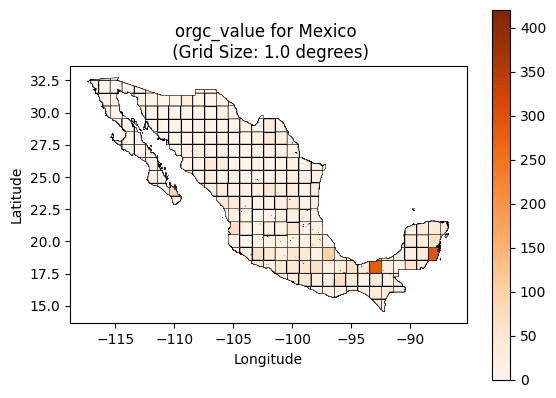

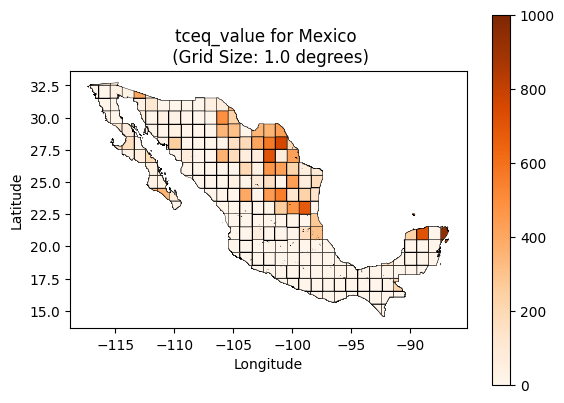

In [152]:
def plot_grid(grid_data, column, title):
    # scatter plot
    grid_data.plot(column=column, cmap='Oranges', legend=True, edgecolor='black', linewidth=0.3)
    # plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# plot grid
for column_grid in interested_column:
    plot_grid(grid_data, column_grid, f'{column_grid} for {plotName} \n (Grid Size: {grid_size} degrees)')